In [3]:
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import nltk

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix


%matplotlib inline


# Getting Data & Assigning Sentiment

In [4]:
review_df = pd.read_csv('../smp_data/ME_NH_RI_reviews.csv', encoding='utf-8')

/Users/angelavierling-claassen/anaconda/envs/my_projects_env/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
cnt_df = review_df[['profID','department']].groupby('profID').count().reset_index().rename(columns={'department': 'reviewcount'})
review_df = pd.merge(review_df,cnt_df,on='profID')

In [6]:
# get rid of any of the middle reviews, trying to balance positive and negative
revPosNeg = review_df.ix[(review_df['overall']<=2.0) | (review_df['overall'] == 5.0)]
revPosNeg = revPosNeg[['profID','genderBest','schoolname_s','department','overall','difficulty','cleanText','reviewcount']]

In [7]:
# assign sentiment positive or negative
# need to do vectorized version of this
def sentiment(row):
    if row['overall'] == 5:
        val = 1
    elif row['overall'] <= 2.0:
        val = 0
    else:
        val = -1
    return val

In [8]:
revPosNeg['sentiment'] = revPosNeg.apply(sentiment,axis=1)

In [9]:
#Basic Sentiment Counts by gender
revPosNeg[['genderBest','sentiment','profID']].groupby(['genderBest','sentiment']).count()

profID
genderBest sentiment        
female     0           15821
           1           22093
male       0           23989
           1           36792

In [10]:
cnt_df = revPosNeg[['profID','reviewcount','sentiment']].groupby(['profID','sentiment']).count().reset_index()
prof_df = revPosNeg[['profID','genderBest']].drop_duplicates()

In [11]:
cnt_df = pd.merge(prof_df,cnt_df,on='profID',how='left')

In [12]:
cnt_df[['genderBest','sentiment','reviewcount']].groupby(['genderBest','sentiment']).mean().reset_index()

,genderBest,sentiment,reviewcount
0,female,0,4.307378
1,female,1,4.464134
2,male,0,5.228640
3,male,1,5.702418


In [15]:
#Reviews per prof, gender & pos/neg
genderSent_df = revPosNeg[['profID','genderBest','sentiment','overall']].groupby(['profID','genderBest','sentiment'])

In [17]:
#Basic Sentiment Counts by gender and department
countDepts = revPosNeg[['genderBest','sentiment','profID','department']].groupby(['genderBest','sentiment','department']).count().rename(columns={'profID':'count'})


In [18]:
# looking for sufficiently large departments to compare
# english and math seem to be it!
# both have counts of larger than 1000 in positive and negative reviews for men and women
countDepts[countDepts['count']>800]

count
genderBest sentiment department              
female     0         Biology              839
                     English             2031
                     Mathematics         1183
                     Psychology           965
           1         Biology             1024
                     Communication        924
                     Education            806
                     English             3339
                     Mathematics         1589
                     Psychology          1970
male       0         Accounting           899
                     Biology             1072
                     Business             985
                     Chemistry           1059
                     Computing           1039
                     Economics           1507
                     English             1575
                     History             1364
                     Mathematics         2899
                     Philosophy           989
                     Psychology          1343
                     Science              869
           1         Accounting           885
                     Biology             1611
                     Business            2399
                     Communication        853
                     Computing           1034
                     Economics           1300
                     English             3531
                     Fine Arts            804
                     History             2177
                     Mathematics         2851
                     Philosophy          1305
                     Political Science   1478
                     Psychology          2369
                     Science             1263
                     Sociology            815

In [280]:
#Deciding which counts to include for departments
test = revPosNeg[revPosNeg.groupby(['genderBest','department']).genderBest.transform(len) > 1000]
depts = test['department'].unique()

In [287]:
#selecting just those departments
revDepts_df = revPosNeg[revPosNeg['department'].isin(depts)].sort_values(by='department')

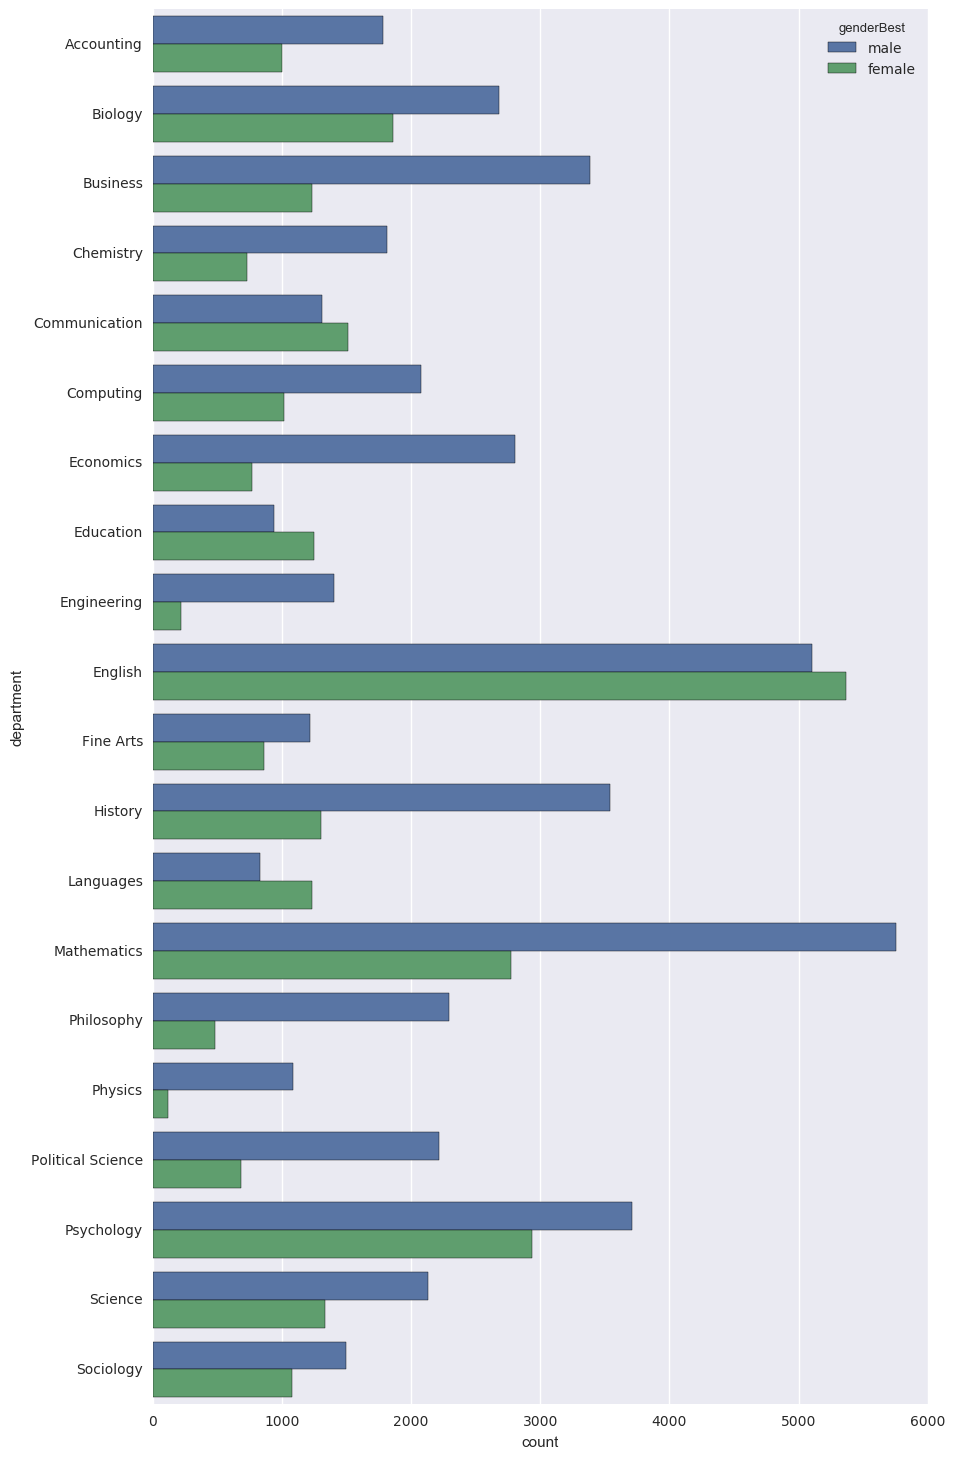

In [288]:
sns.countplot(y="department", data=revDepts_df, hue='genderBest');

In [62]:
# Using snowball stemmer as it is improvement over Porter for reasons I do not know
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

stopwords = nltk.corpus.stopwords.words('english')

# return content words and their stems
def content_stems(text, stopwords):
    tokens = nltk.word_tokenize(text)
    content = [word for word in tokens if word.lower() not in stopwords]
    stems = [stemmer.stem(t) for t in content]
    return [content,stems]

In [ ]:
# try using nltk.ConditionalFrequencyDistribution
# first tokenize and stem the reviews
revPosNeg['stems'] = revPosNeg['cleanText'].apply(lambda x: content_stems(x,stopwords)[1])

In [100]:
revPosNeg['words'] = revPosNeg['cleanText'].apply(lambda x: content_stems(x,stopwords)[0])

# Sentiment by Department & Gender

In [321]:
engMath_df = revPosNeg[revPosNeg['department'].isin(['English','Mathematics'])]

In [367]:
# now define category, word pairs
def pairsDeptGend(rev_df):
    pairList=[]
    for row in rev_df:
        cat = str(rev_df['sentiment'])+rev_df['department']+rev_df['genderBest']
        pairList.extend([(cat,stem) for stem in rev_df['stems']])
    return pairList

In [322]:
# try using nltk.ConditionalFrequencyDistribution
# first tokenize and stem the reviews
engMath_df['stems'] = engMath_df['cleanText'].apply(lambda x: content_stems(x,stopwords)[1])

/Users/angelavierling-claassen/anaconda/envs/my_projects_env/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [650]:
# export this to csv
engMath_df.to_csv('../smp_data/engMath_ME_NH_RI.csv',encoding='utf-8', header=True, index=False)

In [368]:
pairList = engMath_df.apply(pairsDeptGend,axis=1)

In [369]:
pairList = list(itertools.chain(*list(pairList)))

In [371]:
# Conditional frequency distribution
cfd = nltk.ConditionalFreqDist(pairList)

In [653]:
cfd

ConditionalFreqDist(nltk.probability.FreqDist,
                    {'0EnglishFemale': FreqDist(),
                     '0EnglishMale': FreqDist(),
                     '0Englishfemale': FreqDist({'heart': 144,
                               'nosi': 9,
                               'doesnt': 2430,
                               'cloth': 9,
                               'murphi': 9,
                               'hungri': 9,
                               'stand': 99,
                               'gone': 27,
                               'everyth': 594,
                               'capabl': 18,
                               'disappear': 9,
                               'harass': 9,
                               'essay': 972,
                               'wright': 9,
                               'kindergarden': 9,
                               'teagu': 27,
                               'onlin': 315,
                               'flight': 9,
                            

In [634]:
# code for these dataframes and fields
# letter 1 = Bad / Good (corresponding to 0 or 1 on 'sentiment')
# letter 2 = English / Math (with an N for 'number')
# letter 3 = Female / Male
BEF_df = pd.DataFrame.from_dict(cfd['0Englishfemale'],orient='index').rename(columns={0:'BEF'}).reset_index() 
BEM_df = pd.DataFrame.from_dict(cfd['0Englishmale'],orient='index').rename(columns={0:'BEM'}).reset_index() 
BE_df = pd.merge(BEF_df,BEM_df,on='index')

BNF_df = pd.DataFrame.from_dict(cfd['0Mathematicsfemale'],orient='index').rename(columns={0:'BNF'}).reset_index() 
BNM_df = pd.DataFrame.from_dict(cfd['0Mathematicsmale'],orient='index').rename(columns={0:'BNM'}).reset_index() 
BN_df = pd.merge(BNF_df,BNM_df,on='index')

GEF_df = pd.DataFrame.from_dict(cfd['1Englishfemale'],orient='index').rename(columns={0:'GEF'}).reset_index() 
GEM_df = pd.DataFrame.from_dict(cfd['1Englishmale'],orient='index').rename(columns={0:'GEM'}).reset_index() 
GE_df = pd.merge(GEF_df,GEM_df,on='index')

GNF_df = pd.DataFrame.from_dict(cfd['1Mathematicsfemale'],orient='index').rename(columns={0:'GNF'}).reset_index() 
GNM_df = pd.DataFrame.from_dict(cfd['1Mathematicsmale'],orient='index').rename(columns={0:'GNM'}).reset_index() 
GN_df = pd.merge(GNF_df,GNM_df,on='index')

words_df = pd.merge(BE_df,BN_df,on='index')
words_df = pd.merge(words_df,GE_df,on='index')
words_df = pd.merge(words_df,GN_df,on='index')



In [635]:
words_df.head()

,index,BEF,BEM,BNF,BNM,GEF,GEM,GNF,GNM
0,heart,144,18,27,45,162,72,45,117
1,doesnt,2430,1764,1485,4419,621,855,513,846
2,stand,99,126,63,252,90,90,45,45
3,everyth,594,558,306,1323,603,801,1143,1359
4,onlin,315,396,378,873,432,486,441,450


In [636]:
# total up all of the previously defined columns
# turn that into a df to graph
totals = words_df[['index','BEF', 'BEM', 'BNF', 'BNM', 'GEF', 'GEM', 'GNF', 'GNM']].sum()
tot_df = pd.DataFrame(totals).drop('index').rename(columns={0:'count'}).reset_index()
# total of 2370654 words in B G E M F M
tot_df['relCount'] = tot_df['count'] / 2370654


In [647]:
totals

index    heartdoesntstandeverythonlinschedulsummerhalfw...
BEF                                                 252504
BEM                                                 192960
BNF                                                 150696
BNM                                                 373662
GEF                                                 405675
GEM                                                 407637
GNF                                                 198927
GNM                                                 342999
dtype: object

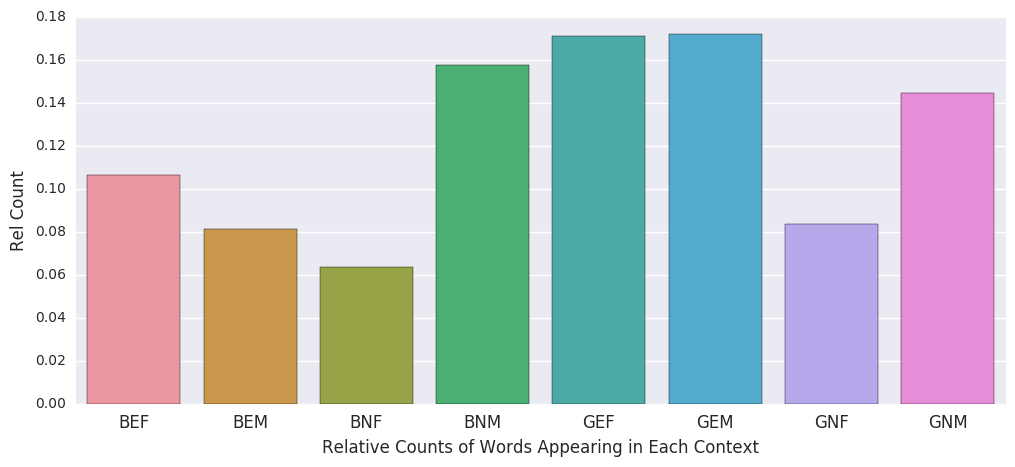

In [637]:
# barplot of counts for all different
plt.rcParams["figure.figsize"] = [12,5]
plt.figure()
sns.barplot(x='index',y='relCount',data = tot_df)
xticks = ['BEF', 'BEM', 'BNF', 'BNM', 'GEF', 'GEM', 'GNF', 'GNM']
plt.xticks(range(len(xticks)),xticks,fontsize=12)
plt.xlabel("Relative Counts of Words Appearing in Each Context",fontsize=12)
plt.ylabel("Rel Count",fontsize=12)
plt.show()

In [638]:
# relative frequency
# in each category these give a ratio for each word of
# num time word present / total words 
words_df['r_BEF'] = words_df['BEF']/totals['BEF']
words_df['r_BEM'] = words_df['BEM']/totals['BEM']
words_df['r_BNF'] = words_df['BNF']/totals['BNF']
words_df['r_BNM'] = words_df['BNM']/totals['BNM']
words_df['r_GEF'] = words_df['GEF']/totals['GEF']
words_df['r_GEM'] = words_df['GEM']/totals['GEM']
words_df['r_GNF'] = words_df['GNF']/totals['GNF']
words_df['r_GNM'] = words_df['GNM']/totals['GNM']

In [639]:
words_df.head()

,index,BEF,BEM,BNF,BNM,GEF,GEM,GNF,GNM,r_BEF,r_BEM,r_BNF,r_BNM,r_GEF,r_GEM,r_GNF,r_GNM
0,heart,144,18,27,45,162,72,45,117,0.000570,0.000093,0.000179,0.000120,0.000399,0.000177,0.000226,0.000341
1,doesnt,2430,1764,1485,4419,621,855,513,846,0.009624,0.009142,0.009854,0.011826,0.001531,0.002097,0.002579,0.002466
2,stand,99,126,63,252,90,90,45,45,0.000392,0.000653,0.000418,0.000674,0.000222,0.000221,0.000226,0.000131
3,everyth,594,558,306,1323,603,801,1143,1359,0.002352,0.002892,0.002031,0.003541,0.001486,0.001965,0.005746,0.003962
4,onlin,315,396,378,873,432,486,441,450,0.001248,0.002052,0.002508,0.002336,0.001065,0.001192,0.002217,0.001312


In [644]:
words_df.columns

Index(['index', 'BEF', 'BEM', 'BNF', 'BNM', 'GEF', 'GEM', 'GNF', 'GNM',
       'r_BEF', 'r_BEM', 'r_BNF', 'r_BNM', 'r_GEF', 'r_GEM', 'r_GNF', 'r_GNM',
       'BE', 'BN', 'GE', 'GN'],
      dtype='object')

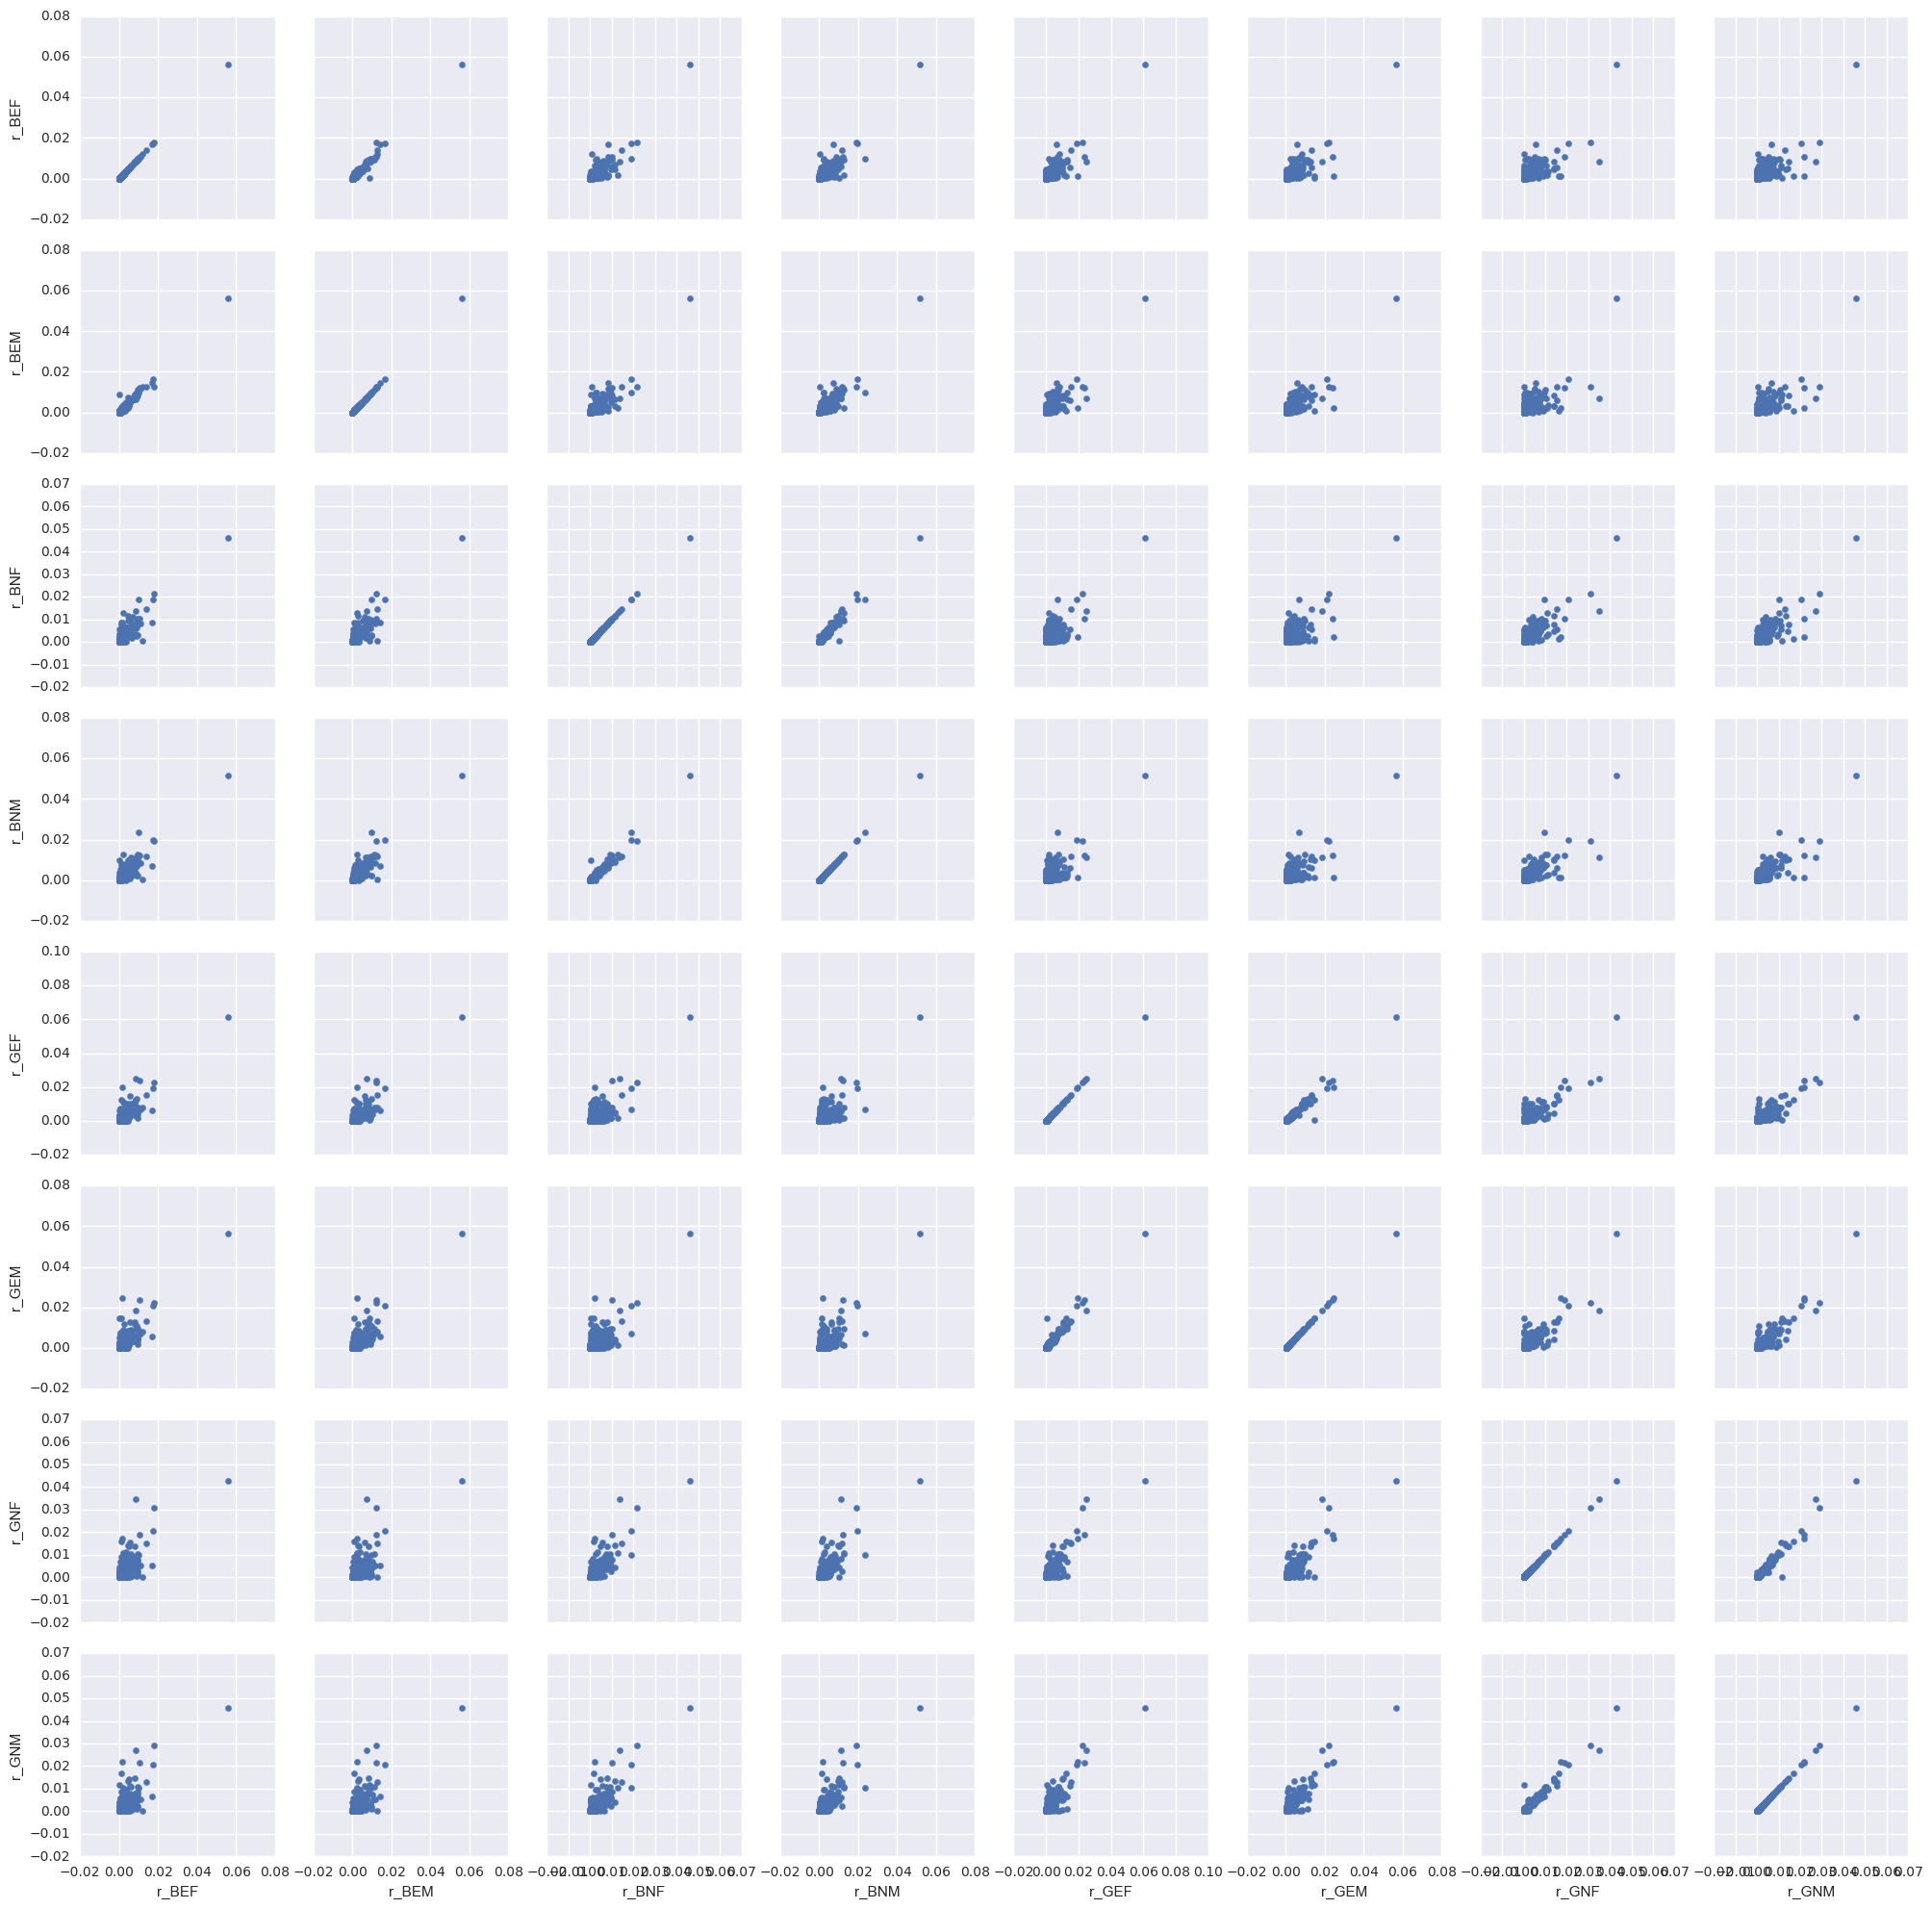

In [645]:
g = sns.PairGrid(words_df[['r_BEF', 'r_BEM', 'r_BNF', 'r_BNM', 'r_GEF', 'r_GEM', 'r_GNF', 'r_GNM']])
g.map(plt.scatter);

In [640]:
# There will be 3 axis we can think of these 8 codes as occuring along
# Get them by holding two of the features constant and only allowing one to vary
# on each, produce a number by taking differnce over sum
# the result will vary from -1 to 1
# closer to zero means the word doesn't differentiate much along that axis
# negative indicates the two categories are 'flipped' in how often they appear

# gender ratings
words_df['BE'] = (words_df['r_BEF']-words_df['r_BEM'])/(words_df['r_BEF']+words_df['r_BEM'])
words_df['BN'] = (words_df['r_BNF']-words_df['r_BNM'])/(words_df['r_BNF']+words_df['r_BNM'])
words_df['GE'] = (words_df['r_GEF']-words_df['r_GEM'])/(words_df['r_GEF']+words_df['r_GEM'])
words_df['GN'] = (words_df['r_GNF']-words_df['r_GNM'])/(words_df['r_GNF']+words_df['r_GNM'])

## Waiting to do rest

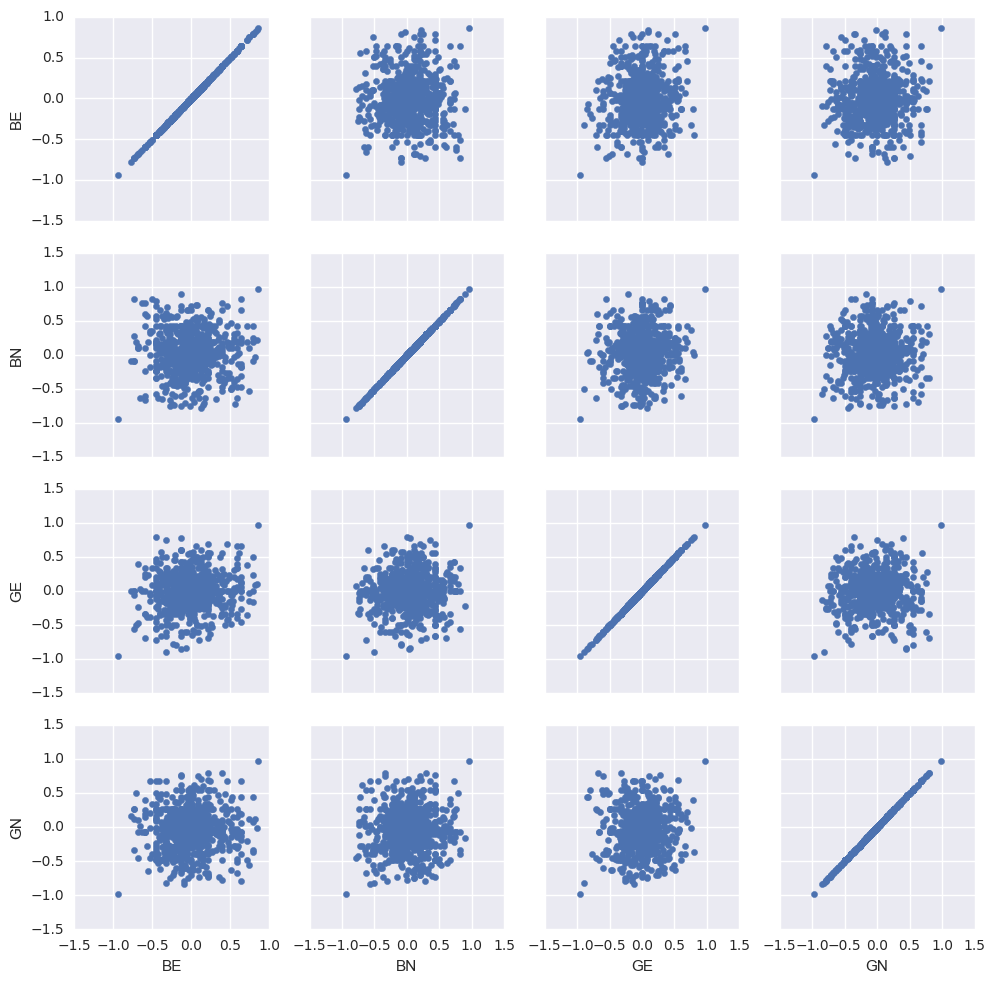

In [646]:
g = sns.PairGrid(words_df[['BE', 'BN', 'GE', 'GN']])
g.map(plt.scatter);

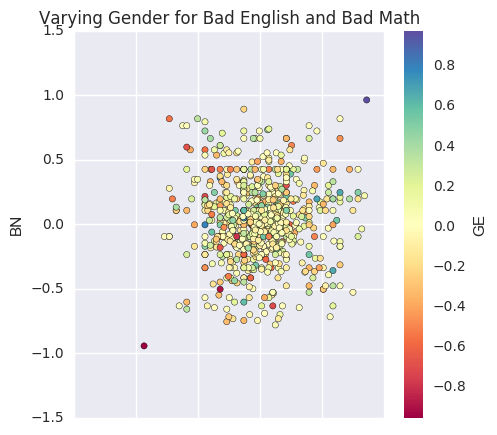

In [642]:
plt.rcParams["figure.figsize"] = [5,5]
plt.figure()


words_df.plot(
    kind='scatter',
    x='BE',
    y='BN',
    title="Varying Gender for Bad English and Bad Math",
    c = 'GE', #color
    cmap = 'Spectral'
)
#plt.xlim([-0.0001,0.05])
#plt.legend(['English Bad','Math Bad', 'English Good','Math Good'], loc=1, fontsize=12)
plt.show()

In [423]:
words_df['diffBE'] = words_df['r_BEF']-words_df['r_BEM']
words_df['diffGE'] = words_df['r_GEF']-words_df['r_GEM']
words_df['diffBM'] = words_df['r_BMF']-words_df['r_BMM']
words_df['diffGM'] = words_df['r_GMF']-words_df['r_GMM']


In [430]:
words_df['diffBF'] = words_df['r_BEF']-words_df['r_BMF']
words_df['diffBMale'] = words_df['r_BEM']-words_df['r_BMM']
words_df['diffGF'] = words_df['r_GEF']-words_df['r_GMF']
words_df['diffGMale'] = words_df['r_GEM']-words_df['r_GMM']


#words_df['ratioDiffEM'] = words_df['diffEng']/words_df['diffMath']
#words_df['ratioDiffBG'] = words_df['diffBad']/words_df['diffGood']


In [460]:
graphBad_df = words_df[(abs(words_df['diffBF'])>.005)|(abs(words_df['diffBMale'])>.005)].sort_values("diffBF")

In [461]:
graphBad_df

,index,BEF,BEM,BMF,BMM,GEF,GEM,GMF,GMM,r_BEF,...,r_GMF,r_GMM,diffBE,diffGE,diffBM,diffGM,diffBF,diffBMale,diffGF,diffGMale
226,test,468,423,1926,4689,630,594,1926,4689,0.001778,...,0.012409,0.012179,-0.000323,0.000093,0.000230,0.000230,-0.010631,-0.010078,-0.010880,-0.010743
33,teach,2520,1863,2844,8874,2790,2817,2844,8874,0.009574,...,0.018323,0.023049,0.000321,-0.000039,-0.004726,-0.004726,-0.008749,-0.013796,-0.011552,-0.016238
177,homework,333,198,1278,2232,648,261,1278,2232,0.001265,...,0.008234,0.005797,0.000282,0.000942,0.002437,0.002437,-0.006969,-0.004814,-0.006661,-0.005166
637,understand,1107,585,1719,3708,1746,1656,1719,3708,0.004206,...,0.011075,0.009631,0.001300,0.000234,0.001444,0.001444,-0.006869,-0.006725,-0.006838,-0.005627
648,materi,423,549,1278,2646,1044,1233,1278,2646,0.001607,...,0.008234,0.006873,-0.001120,-0.000447,0.001361,0.001361,-0.006627,-0.004146,-0.005700,-0.003891
470,problem,252,252,1152,2880,324,288,1152,2880,0.000957,...,0.007422,0.007480,-0.000294,0.000090,-0.000058,-0.000058,-0.006465,-0.006229,-0.006636,-0.006784
343,help,2115,1359,2043,4248,10116,7560,2043,4248,0.008035,...,0.013162,0.011033,0.001285,0.006273,0.002129,0.002129,-0.005127,-0.004284,0.011389,0.007245
584,explain,549,405,1089,3060,531,459,1089,3060,0.002086,...,0.007016,0.007948,0.000074,0.000179,-0.000932,-0.000932,-0.004930,-0.005936,-0.005727,-0.006838
312,teacher,4527,2403,3231,7218,9207,9027,3231,7218,0.017199,...,0.020816,0.018748,0.005264,0.000520,0.002069,0.002069,-0.003617,-0.006812,0.001529,0.003077
294,assign,2412,1872,459,882,2340,1530,459,882,0.009164,...,0.002957,0.002291,-0.000134,0.001980,0.000666,0.000666,0.006206,0.007007,0.002722,0.001408


In [426]:
chooseWords = ['wrong','write','work','wonder','sweet','told','help','understand','rude','read','nice','love','late','help','hard','grade','give','feedback','favorite','easi','due','care','away','assign','board','horribl','paper','speak','english','quiz','homework','mistak','exampl','homework']
wordsChosen_df = words_df[words_df['index'].isin(chooseWords)]

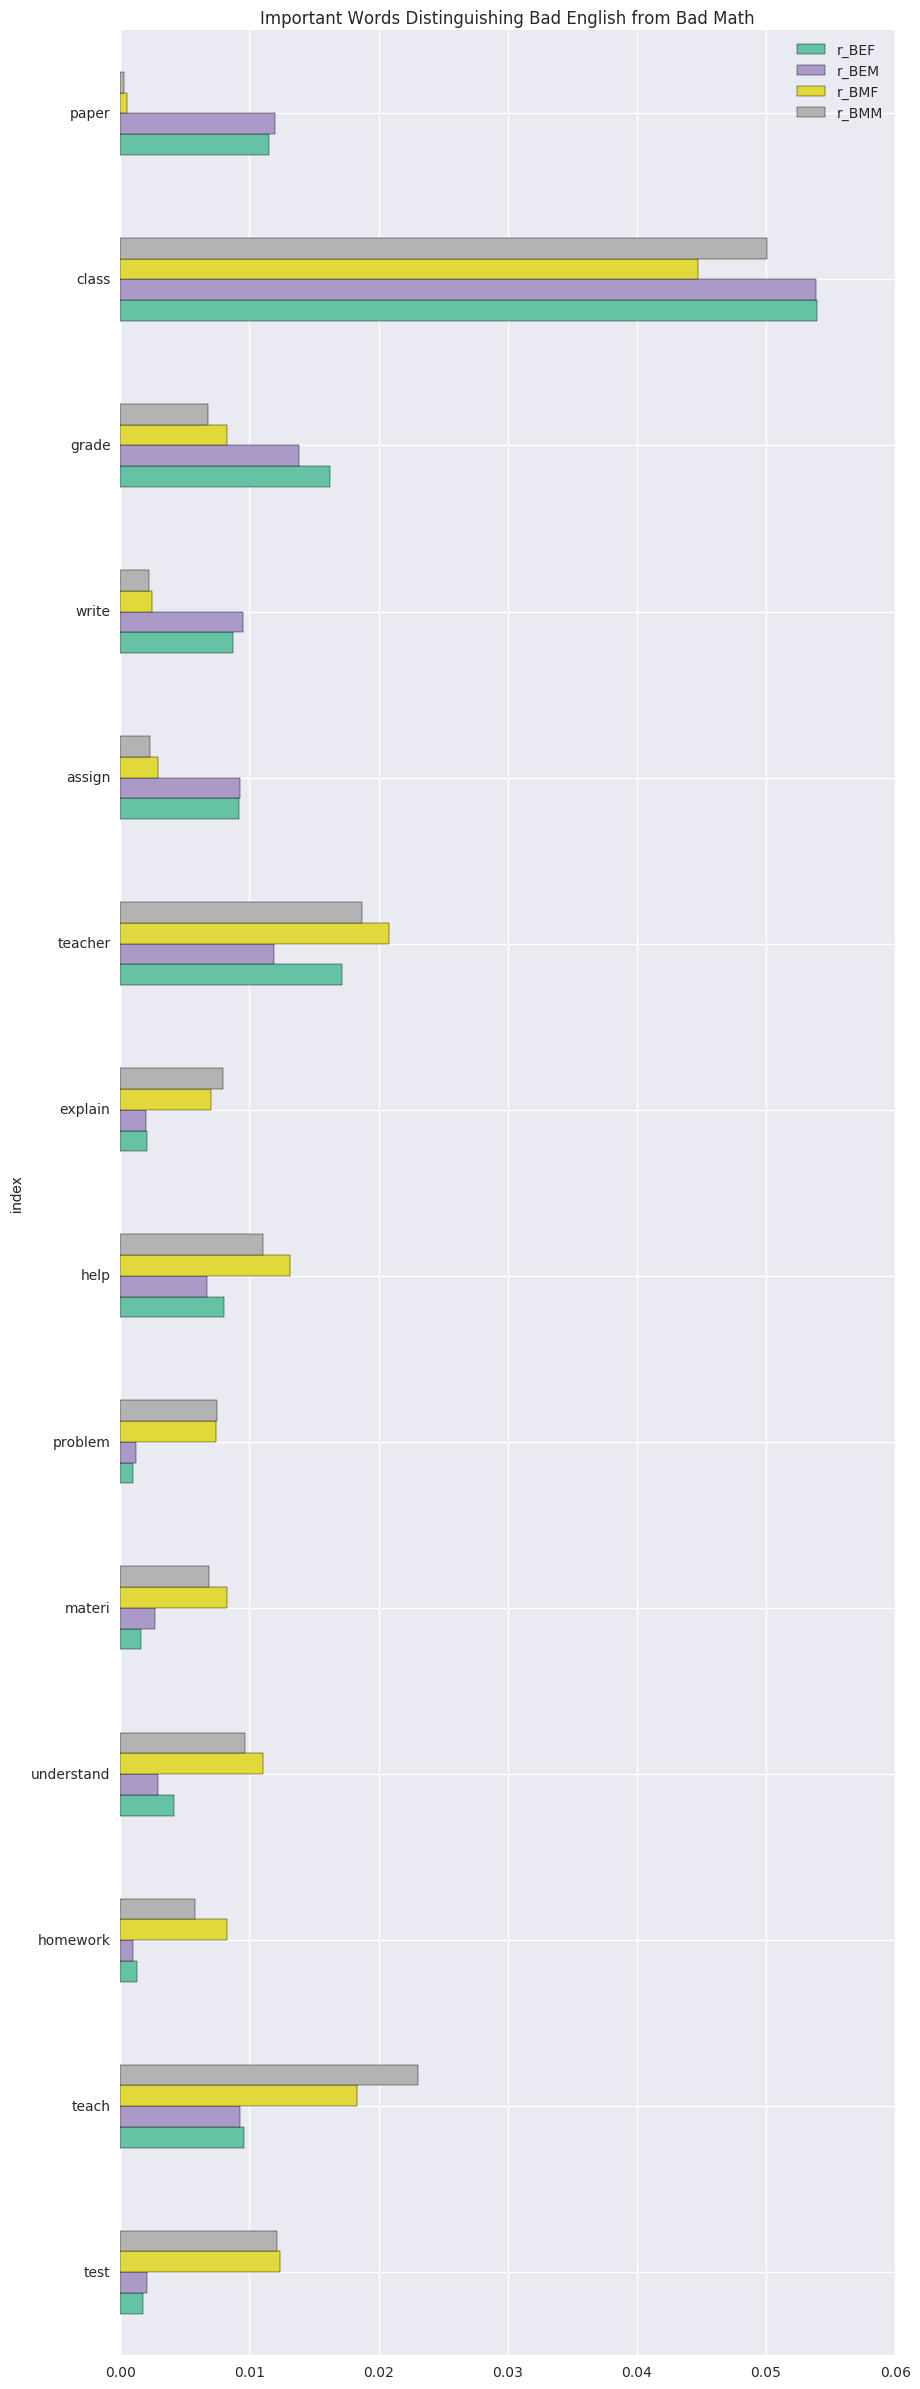

In [459]:
plt.rcParams["figure.figsize"] = [10,30]
plt.figure()


graphBad_df[['index','r_BEF','r_BEM','r_BMF', 'r_BMM']].plot(
    kind='barh',
    x='index',
    title="Important Words Distinguishing Bad English from Bad Math",
    cmap=plt.cm.Set2
)
#plt.xlim([-0.0001,0.05])
#plt.legend(['English Bad','Math Bad', 'English Good','Math Good'], loc=1, fontsize=12)
plt.show()

In [480]:
graphBad_df = words_df[(abs(words_df['diffBE'])>.002)|(abs(words_df['diffBM'])>.002)].sort_values("diffBE")

In [481]:
graphBad_df

,index,BEF,BEM,BMF,BMM,GEF,GEM,GMF,GMM,r_BEF,...,r_GMF,r_GMM,diffBE,diffGE,diffBM,diffGM,diffBF,diffBMale,diffGF,diffGMale
119,guy,72,1728,45,3726,135,6021,45,3726,0.000274,...,0.000290,0.009678,-0.008309,-0.014229,-0.009388,-0.009388,-0.000016,-0.001095,0.000038,0.004879
505,learn,1215,1467,963,2952,3285,3411,963,2952,0.004616,...,0.006204,0.007667,-0.002670,-0.000274,-0.001463,-0.001463,-0.001588,-0.000381,0.001768,0.000580
892,ever,2340,2205,1413,4752,3150,3951,1413,4752,0.008890,...,0.009104,0.012343,-0.002062,-0.001907,-0.003239,-0.003239,-0.000213,-0.001391,-0.001459,-0.002790
163,professor,2664,2349,1521,4572,9594,9711,1521,4572,0.010121,...,0.009799,0.011875,-0.001546,-0.000194,-0.002076,-0.002076,0.000322,-0.000208,0.013485,0.011603
467,lectur,720,711,423,1863,882,1440,423,1863,0.002735,...,0.002725,0.004839,-0.000796,-0.001341,-0.002114,-0.002114,0.000010,-0.001307,-0.000585,-0.001357
830,make,2061,1629,1188,3780,4185,5229,1188,3780,0.007830,...,0.007654,0.009818,-0.000261,-0.002485,-0.002164,-0.002164,0.000176,-0.001727,0.002503,0.002824
886,class,14193,10854,6939,19278,24849,23058,6939,19278,0.053922,...,0.044706,0.050071,0.000013,0.004560,-0.005365,-0.005365,0.009216,0.003838,0.015602,0.005676
177,homework,333,198,1278,2232,648,261,1278,2232,0.001265,...,0.008234,0.005797,0.000282,0.000942,0.002437,0.002437,-0.006969,-0.004814,-0.006661,-0.005166
33,teach,2520,1863,2844,8874,2790,2817,2844,8874,0.009574,...,0.018323,0.023049,0.000321,-0.000039,-0.004726,-0.004726,-0.008749,-0.013796,-0.011552,-0.016238
84,hard,1809,1233,1692,3249,2007,1341,1692,3249,0.006873,...,0.010901,0.008439,0.000749,0.001629,0.002462,0.002462,-0.004028,-0.002315,-0.006030,-0.005197


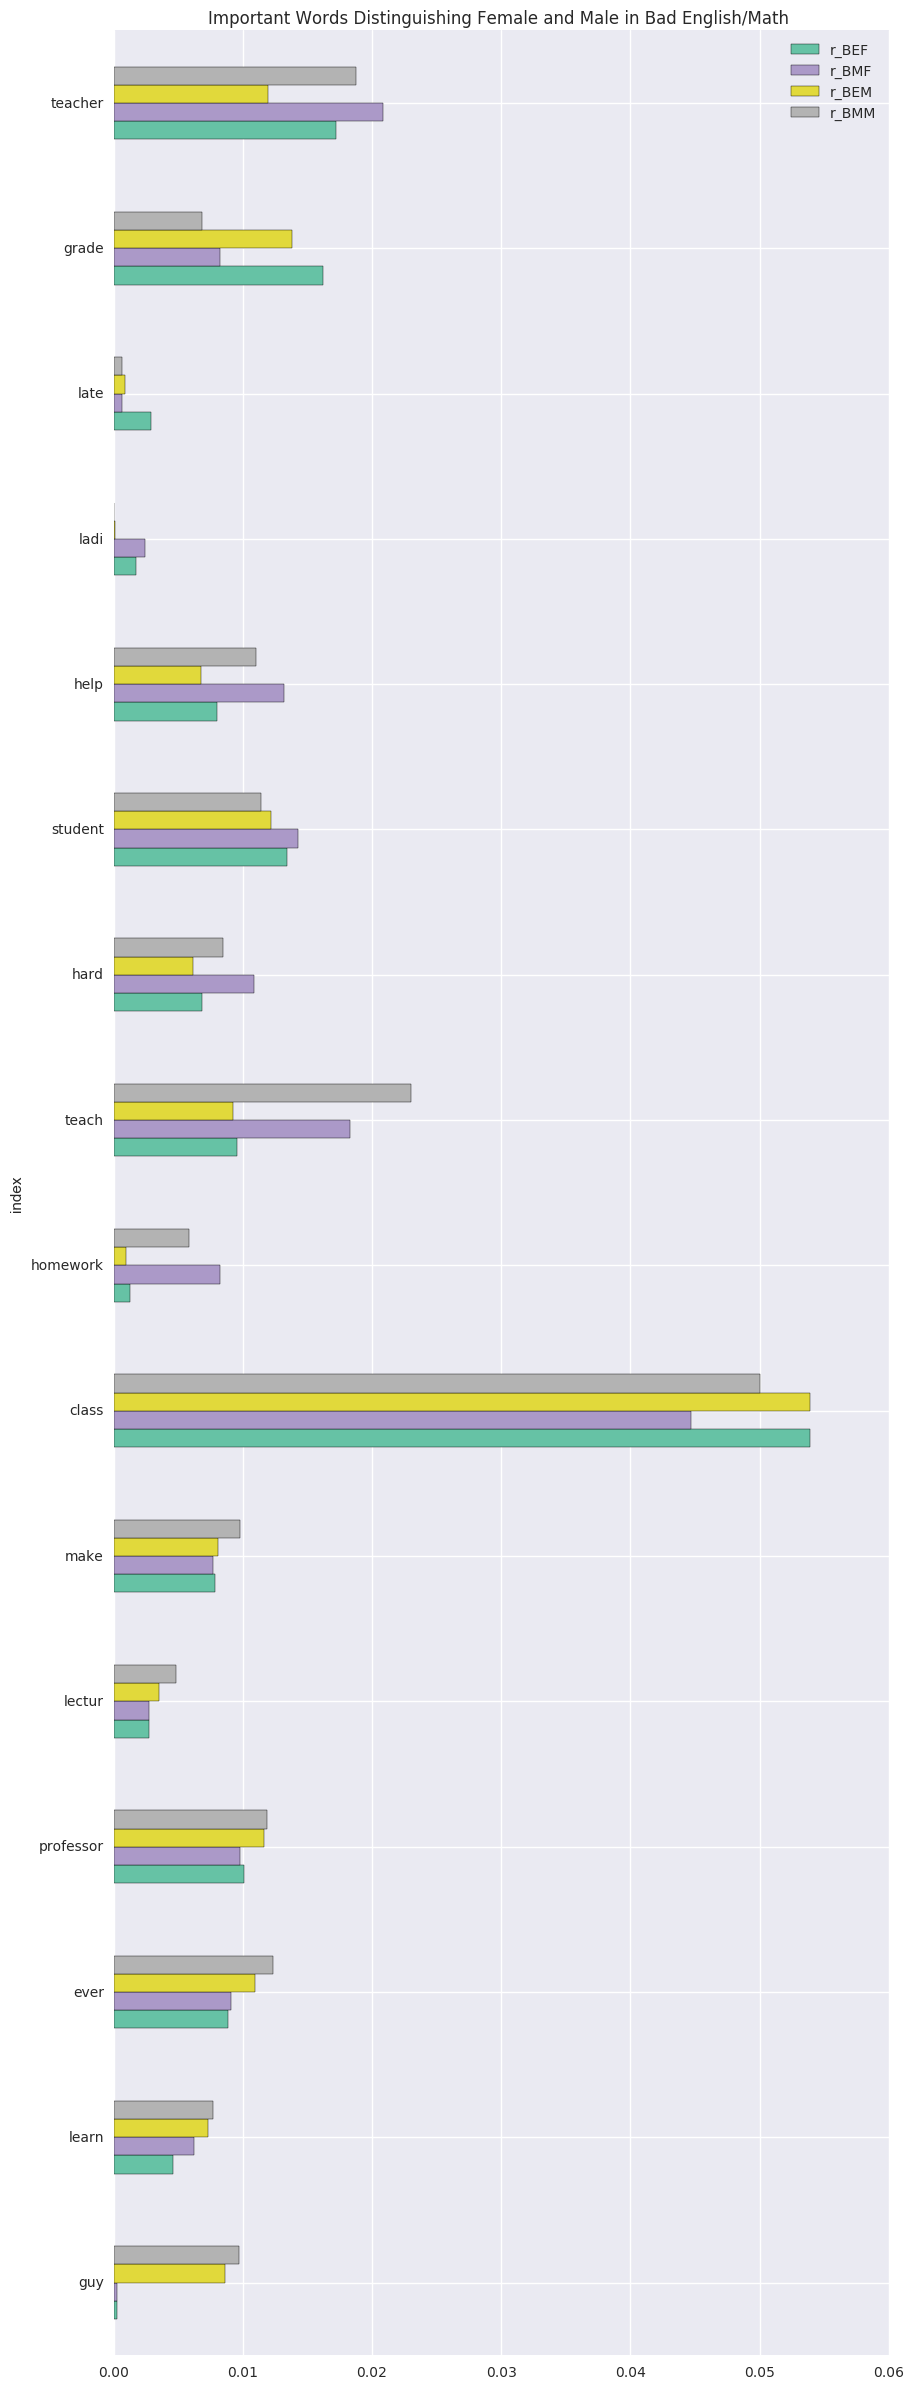

In [482]:
plt.rcParams["figure.figsize"] = [10,30]
plt.figure()


graphBad_df[['index','r_BEF','r_BMF','r_BEM', 'r_BMM']].plot(
    kind='barh',
    x='index',
    title="Important Words Distinguishing Female and Male in Bad English/Math ",
    cmap=plt.cm.Set2
)
#plt.xlim([-0.0001,0.05])
#plt.legend(['English Bad','Math Bad', 'English Good','Math Good'], loc=1, fontsize=12)
plt.show()

In [466]:
graphGood_df = words_df[(abs(words_df['diffGF'])>.008)|(abs(words_df['diffGMale'])>.008)].sort_values("diffBF")

In [467]:
graphGood_df

,index,BEF,BEM,BMF,BMM,GEF,GEM,GMF,GMM,r_BEF,...,r_GMF,r_GMM,diffBE,diffGE,diffBM,diffGM,diffBF,diffBMale,diffGF,diffGMale
226,test,468,423,1926,4689,630,594,1926,4689,0.001778,...,0.012409,0.012179,-0.000323,0.000093,0.000230,0.000230,-0.010631,-0.010078,-0.010880,-0.010743
33,teach,2520,1863,2844,8874,2790,2817,2844,8874,0.009574,...,0.018323,0.023049,0.000321,-0.000039,-0.004726,-0.004726,-0.008749,-0.013796,-0.011552,-0.016238
343,help,2115,1359,2043,4248,10116,7560,2043,4248,0.008035,...,0.013162,0.011033,0.001285,0.006273,0.002129,0.002129,-0.005127,-0.004284,0.011389,0.007245
734,great,360,450,306,585,7956,9945,306,585,0.001368,...,0.001971,0.001519,-0.000867,-0.004735,0.000452,0.000452,-0.000604,0.000716,0.017337,0.022525
1,doesnt,2430,1764,1485,4419,621,855,1485,4419,0.009232,...,0.009567,0.011478,0.000471,-0.000560,-0.001910,-0.001910,-0.000335,-0.002716,-0.008060,-0.009410
500,best,333,171,225,450,5121,5985,225,450,0.001265,...,0.001450,0.001169,0.000416,-0.002042,0.000281,0.000281,-0.000184,-0.000319,0.010979,0.013301
486,realli,1404,1179,819,2259,6057,5265,819,2259,0.005334,...,0.005277,0.005867,-0.000522,0.001971,-0.000591,-0.000591,0.000057,-0.000012,0.009424,0.006862
163,professor,2664,2349,1521,4572,9594,9711,1521,4572,0.010121,...,0.009799,0.011875,-0.001546,-0.000194,-0.002076,-0.002076,0.000322,-0.000208,0.013485,0.011603
437,love,468,360,153,531,4518,3636,153,531,0.001778,...,0.000986,0.001379,-0.000010,0.002174,-0.000393,-0.000393,0.000792,0.000409,0.009979,0.007412
851,interest,630,576,63,450,4248,4842,63,450,0.002393,...,0.000406,0.001169,-0.000467,-0.001397,-0.000763,-0.000763,0.001988,0.001692,0.009904,0.010538


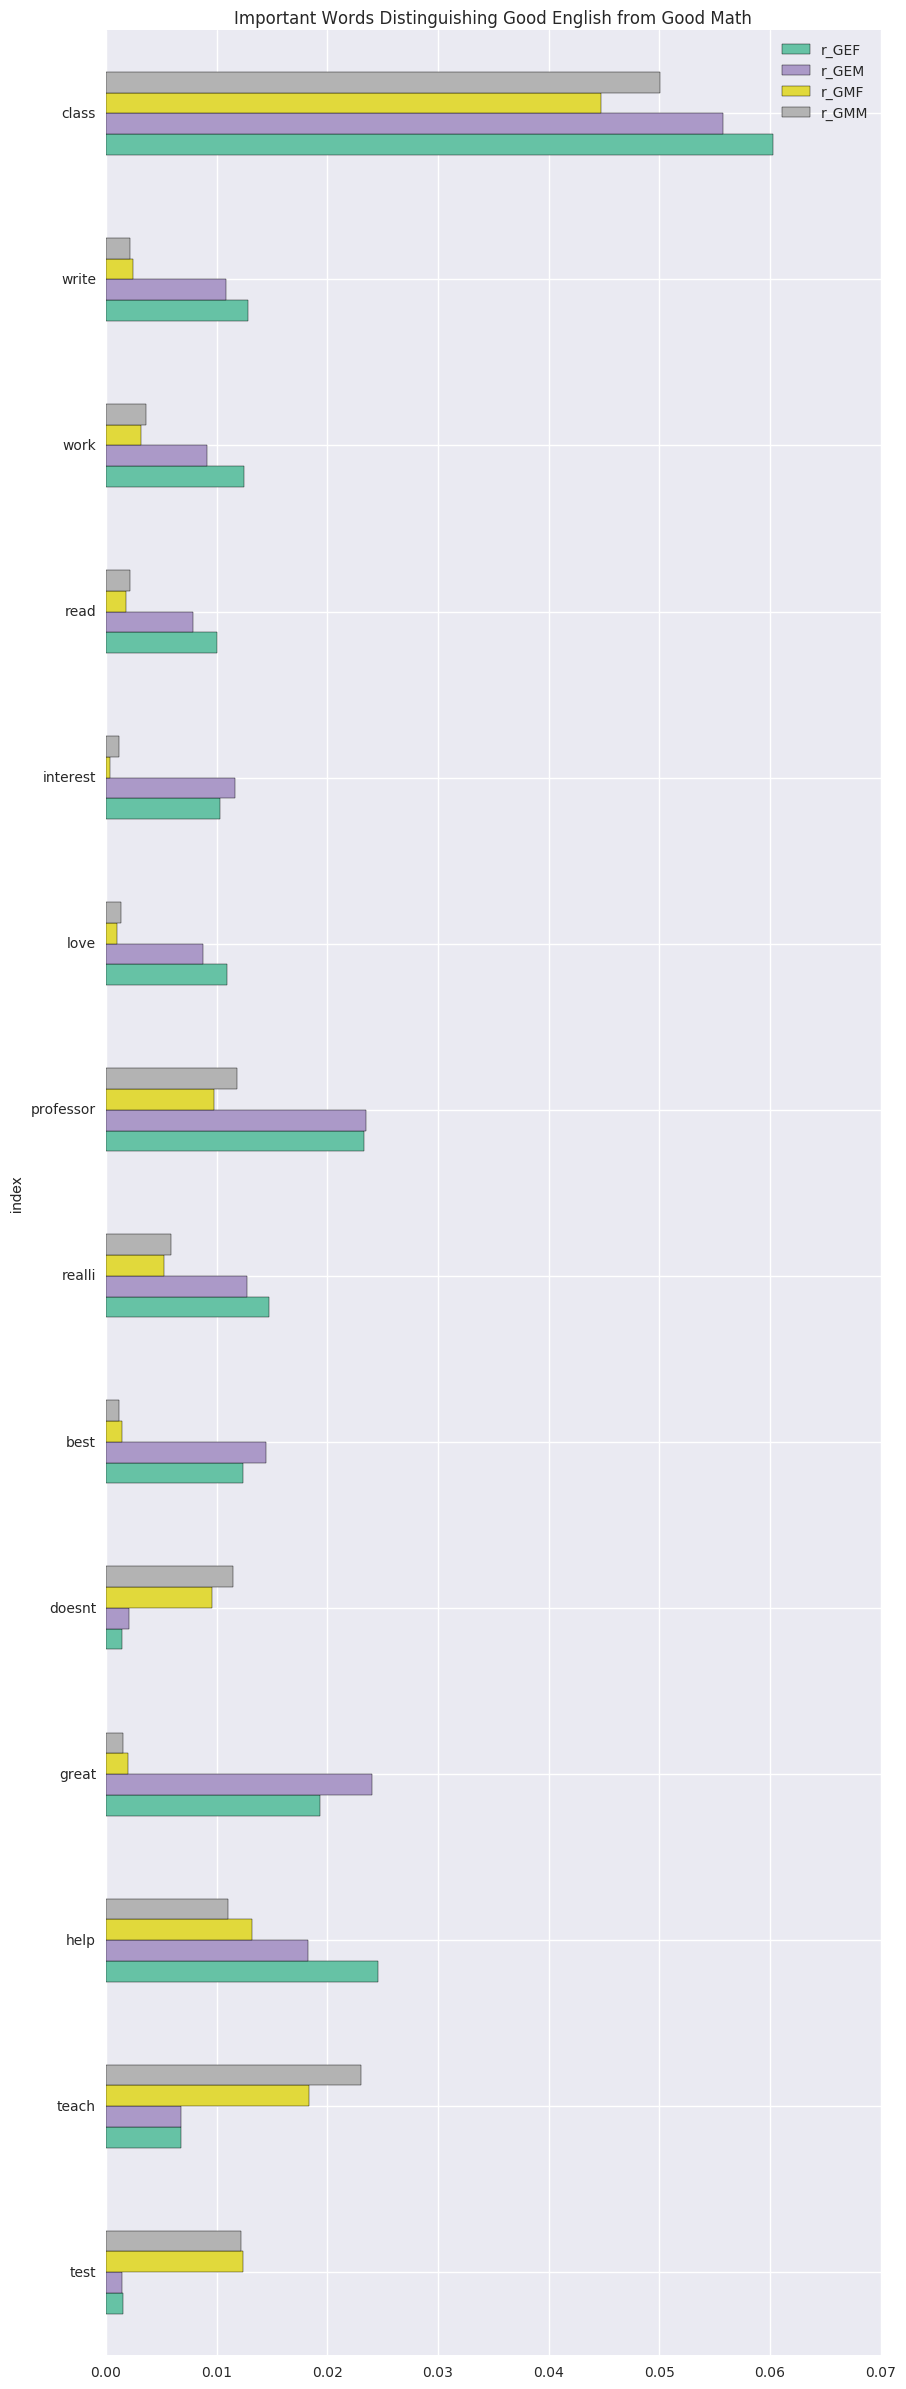

In [468]:
plt.rcParams["figure.figsize"] = [10,30]
plt.figure()


graphGood_df[['index','r_GEF','r_GEM','r_GMF', 'r_GMM']].plot(
    kind='barh',
    x='index',
    title="Important Words Distinguishing Good English from Good Math",
    cmap=plt.cm.Set2
)
#plt.xlim([-0.0001,0.05])
#plt.legend(['English Bad','Math Bad', 'English Good','Math Good'], loc=1, fontsize=12)
plt.show()

In [361]:
chooseWords = ['instructor','professor','teacher','faculty','lecturer','prof']
wordsChosen_df = words_df[words_df['index'].isin(chooseWords)]

In [362]:
wordsChosen_df

,index,engBad,engGood,mathBad,mathGood,r_engBad,r_engGood,r_mathBad,r_mathGood,diffBad,diffGood,diffEng,diffMath,ratioDiffEM,ratioDiffBG
255,professor,5013,19305,6093,11187,0.010116,0.021642,0.010448,0.018553,-0.000331,0.003089,0.011526,0.008105,1.422050,-0.107301
505,teacher,6930,18234,10449,16074,0.013984,0.020441,0.017917,0.026657,-0.003932,-0.006216,0.006457,0.008740,0.738706,0.632589
959,prof,774,4194,972,2196,0.001562,0.004702,0.001667,0.003642,-0.000105,0.001060,0.003140,0.001975,1.589604,-0.098850
1027,instructor,396,1026,279,774,0.000799,0.001150,0.000478,0.001284,0.000321,-0.000133,0.000351,0.000805,0.436009,-2.403997


In [349]:
graphWords_df = words_df[(words_df['diffEng']>.002)&(words_df['diffMath']>.002)].sort_values("index")

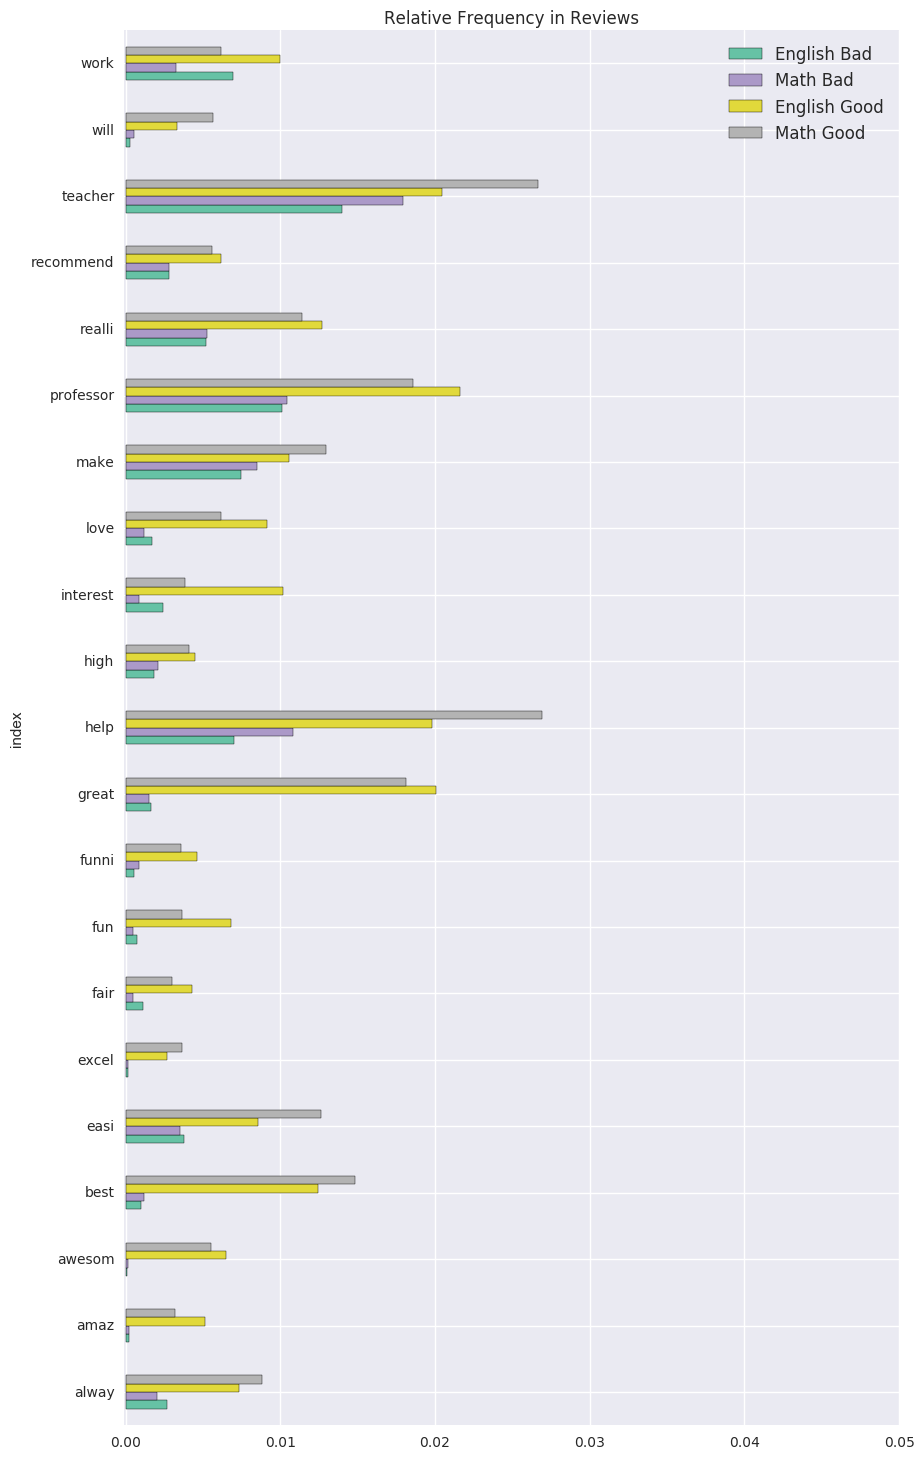

In [366]:
plt.rcParams["figure.figsize"] = [10,18]
plt.figure()


graphWords_df[['index','r_engBad', 'r_mathBad','r_engGood', 'r_mathGood']].plot(
    kind='barh',
    x='index',
    title="Relative Frequency in Reviews",
    cmap=plt.cm.Set2
)
plt.xlim([-0.0001,0.05])
plt.legend(['English Bad','Math Bad', 'English Good','Math Good'], loc=1, fontsize=12)
plt.show()

# Sentiment and review words by gender

In [ ]:
import itertools

In [33]:
# now define category, word pairs
def pairs(rev_df):
    pairList=[]
    for row in rev_df:
        cat = str(rev_df['sentiment'])+rev_df['genderBest']
        pairList.extend([(cat,stem) for stem in rev_df['stems']])
    return pairList

In [34]:
pairList = revPosNeg.apply(pairs,axis=1)

In [39]:
# Conditional frequency distribution
cfd = nltk.ConditionalFreqDist(pairList)

In [94]:
fbad_df = pd.DataFrame.from_dict(cfd['0female'],orient='index').rename(columns={0:'fBad'}).reset_index() 
fgood_df = pd.DataFrame.from_dict(cfd['1female'],orient='index').rename(columns={0:'fGood'}).reset_index()
mbad_df = pd.DataFrame.from_dict(cfd['0male'],orient='index').rename(columns={0:'mBad'}).reset_index() 
mgood_df = pd.DataFrame.from_dict(cfd['1male'],orient='index').rename(columns={0:'mGood'}).reset_index() 

In [100]:
femaleWord_df = pd.merge(fbad_df,fgood_df,on='index')
maleWord_df = pd.merge(mbad_df,mgood_df,on='index')
words_df = pd.merge(femaleWord_df,maleWord_df,on='index')

In [103]:
totals = words_df.sum()
totals

index    heartfrownhalfweekslicegodfamilireccommendwick...
fBad                                               2344086
fGood                                              3097377
mBad                                               3554442
mGood                                              5036238
dtype: object

In [106]:
words_df['r_fBad'] = words_df['fBad']/totals['fBad']
words_df['r_fGood'] = words_df['fGood']/totals['fGood']
words_df['r_mBad'] = words_df['mBad']/totals['mBad']
words_df['r_mGood'] = words_df['mGood']/totals['mGood']


In [171]:
words_df['diffBad'] = words_df['r_fBad']-words_df['r_mBad']
words_df['diffGood'] = words_df['r_fGood']-words_df['r_mGood']

In [185]:
words_df['diffFem'] = words_df['r_fGood']-words_df['r_fBad']
words_df['diffMale'] = words_df['r_mGood']-words_df['r_mBad']
words_df['ratioDiffFM'] = words_df['diffFem']/words_df['diffMale']
words_df['ratioDiffBG'] = words_df['diffBad']/words_df['diffGood']


In [186]:
words_df.sort_values(by='ratioDiffBG')

,index,fBad,fGood,mBad,mGood,r_fBad,r_fGood,r_mBad,r_mGood,diffBad,diffGood,diffFem,diffMale,ratioDiffFM,ratioDiffBG,absRatioBG
1171,essenti,126,216,783,351,0.000054,0.000070,0.000220,0.000070,-0.000167,4.154598e-08,1.598413e-05,-0.000151,-0.106141,-4008.461468,4008.461468
1362,hit,126,72,234,117,0.000054,0.000023,0.000066,0.000023,-0.000012,1.384866e-08,-3.050682e-05,-0.000043,0.716097,-872.346130,872.346130
1305,unprofession,1377,9,729,18,0.000587,0.000003,0.000205,0.000004,0.000382,-6.684120e-07,-5.845301e-04,-0.000202,2.900586,-572.012933,572.012933
2941,offer,1197,2457,1467,3996,0.000511,0.000793,0.000413,0.000793,0.000098,-1.975576e-07,2.826050e-04,0.000381,0.742279,-495.672106,495.672106
3762,unclear,7101,117,8334,198,0.003029,0.000038,0.002345,0.000039,0.000685,-1.541163e-06,-2.991552e-03,-0.002305,1.297652,-444.244932,444.244932
3734,cumul,99,144,189,234,0.000042,0.000046,0.000053,0.000046,-0.000011,2.769732e-08,4.257005e-06,-0.000007,-0.634460,-394.946463,394.946463
3442,current,432,819,576,1332,0.000184,0.000264,0.000162,0.000264,0.000022,-6.585253e-08,8.012370e-05,0.000102,0.782211,-337.767251,337.767251
130,last,1863,1683,2925,2736,0.000795,0.000543,0.000823,0.000543,-0.000028,1.003314e-07,-2.514031e-04,-0.000280,0.898988,-280.549458,280.549458
2749,dynam,9,216,54,351,0.000004,0.000070,0.000015,0.000070,-0.000011,4.154598e-08,6.589698e-05,0.000055,1.209061,-273.258913,273.258913
3206,packet,189,171,126,279,0.000081,0.000055,0.000035,0.000055,0.000045,-1.904905e-07,-2.542044e-05,0.000020,-1.274214,-237.176389,237.176389


In [229]:
words_df.to_csv('../smp_data/word_gender_ME_NH_RI.csv',encoding='utf-8', header=True, index=False)

In [213]:
graphWords_df = words_df[(words_df['diffFem']/words_df['diffMale']<0)].sort_values("diffFem")

In [226]:
chooseWords = ['sweet','love','nice','care','help','understand','easi','good','best','great','engage','grade','funni','fun','humor','book','paper','write','bore','rude','play']
wordsChosen_df = words_df[words_df['index'].isin(chooseWords)]

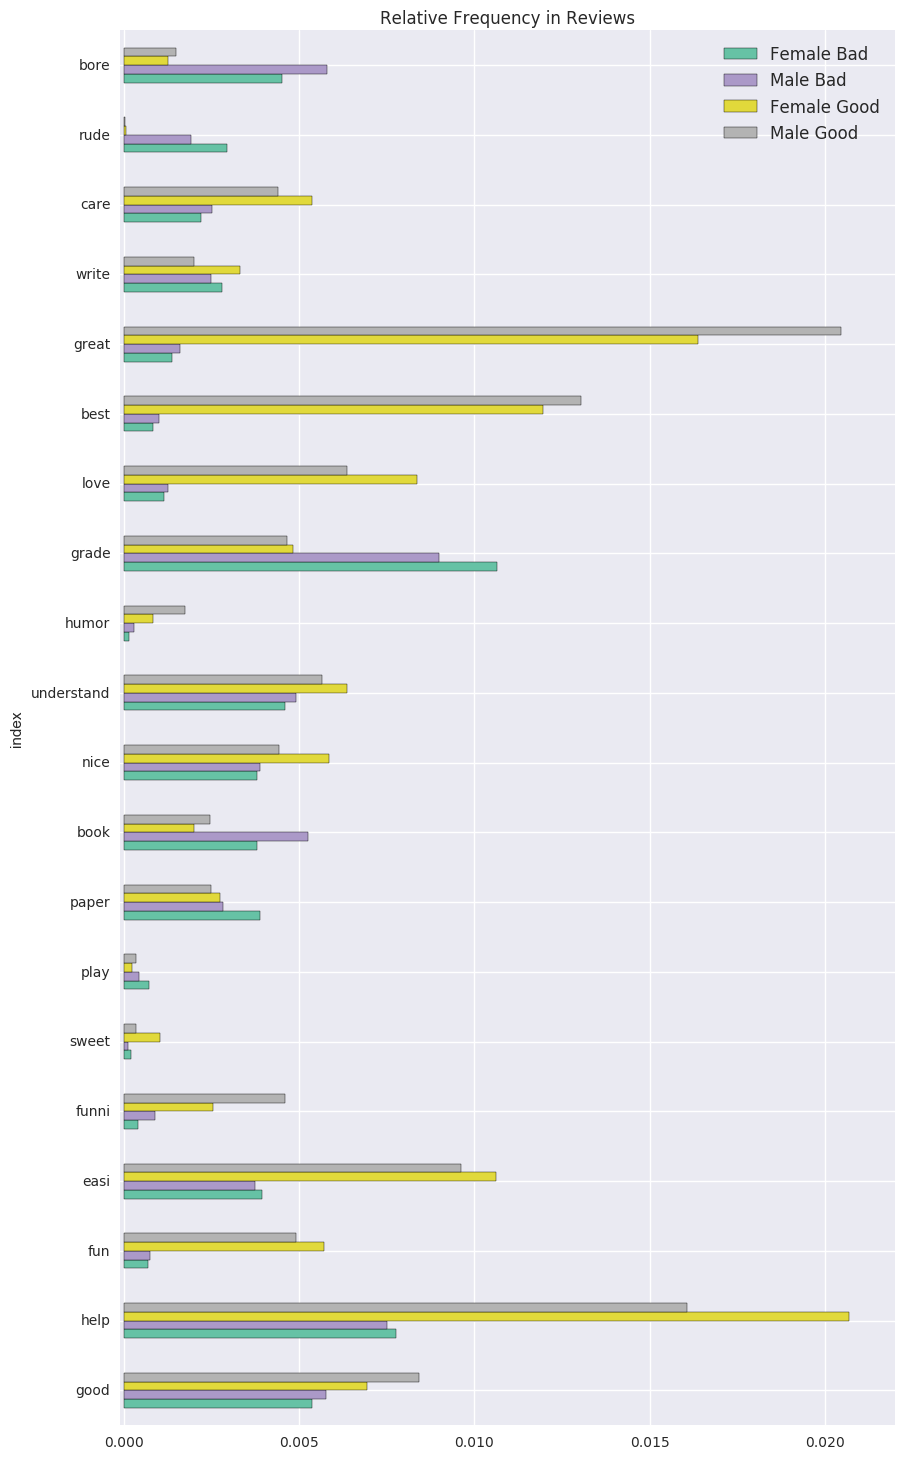

In [227]:
plt.rcParams["figure.figsize"] = [10,18]
plt.figure()


wordsChosen_df[['index','r_fBad', 'r_mBad','r_fGood', 'r_mGood']].plot(
    kind='barh',
    x='index',
    title="Relative Frequency in Reviews",
    cmap=plt.cm.Set2
)
plt.xlim([-0.0001,0.022])
plt.legend(['Female Bad','Male Bad', 'Female Good','Male Good'], loc=1, fontsize=12)
plt.show()

# Predict Sentiment from Text

In [258]:
# Including only departments with over 800 profs for both men & women in both sentiments
revSet_df = revPosNeg[revPosNeg['department'].isin(['English','Mathematics','Biology','Psychology'])]
revSet_df = revSet_df[['profID','genderBest','department','sentiment','cleanText','words']]

In [259]:
# only use reviews where text is not "no comments"
revSet_df = revSet_df[revSet_df['cleanText']!="no comments "]

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [431]:
# pick out the train and the test sets
train_set = revSet_df

#pulling out the test set
test_set = train_set.sample(frac=.2,random_state=2411)
train_set=train_set.drop(test_set.index)
# training to the sentiment
y_train = train_set['sentiment']
y_test = test_set['sentiment']


# Initialize TFIDF vectorizor object (no n-grams)
vectorizer = TfidfVectorizer( max_features = 40000, sublinear_tf = True )

# fit_transform() fits the model & and learns the vocab (features)
# then it transforms the training data into feature vectors. 
# The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(train_set['cleanText'])

# convert to array
train_data_features = train_data_features.toarray()

In [432]:
# vocab = feature names
vocab = vectorizer.get_feature_names()

In [433]:
# Initialize a Random Forest classifier with 100 trees
# oob_score gives "out of bag" errors
forest = RandomForestClassifier(n_estimators = 100,oob_score=True) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit( train_data_features, y_train )

In [434]:
# how does the train set do on the out of bag reviews?
forest.oob_score_

0.92674234424498414

In [404]:
# cross-validation
# note need to update to latest sklearn which has this under sklearn.model_selection
from sklearn import cross_validation

In [412]:
# this cross validation is very costly
# may just want to go with the oob score (note that it is very close to cv score)
scores = cross_validation.cross_val_score(forest, train_data_features, y_train, cv=5)
scores

array([ 0.90739111,  0.8974923 ,  0.90739111,  0.90255169,  0.9040493 ])

In [415]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.90 (+/- 0.01)


In [435]:
# look at result on train data
trainResult = forest.predict(train_data_features)

In [436]:
# confusion matrix for train data
confusion_matrix(train_set["sentiment"], trainResult)

array([[ 8715,    15],
       [    0, 13998]])

# Model Output and Evaluation

In [437]:
# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(test_set['cleanText'])
test_data_features = test_data_features.toarray()

In [439]:
# Use the random forest to make sentiment label predictions
result = forest.predict(test_data_features)

# Copy the results to a pandas dataframe with an "profID" & sentiment prediction
output = pd.DataFrame( data={'sentimentActual':test_set["sentiment"], 'gender':test_set['genderBest'],'depart':test_set['department'], "sentimentPredict":result} )

In [440]:
output.head()

,depart,gender,sentimentActual,sentimentPredict
54508,Psychology,male,0,0
84198,Mathematics,male,1,1
167292,Mathematics,male,0,0
98784,Mathematics,female,1,1
164264,English,male,0,0


In [441]:
confusion_matrix(test_set["sentiment"], result)

array([[1965,  265],
       [  99, 3353]])

In [355]:
# model evaluation
from sklearn.metrics import classification_report

In [442]:
print(classification_report(test_set['sentiment'],result))

             precision    recall  f1-score   support

          0       0.95      0.88      0.92      2230
          1       0.93      0.97      0.95      3452

avg / total       0.94      0.94      0.94      5682



# Which Words are Most Important?

In [373]:
importances = forest.feature_importances_

In [379]:
imp_df = pd.DataFrame({'vocab':vocab,'import':importances}).sort_values('import')

In [452]:
# important words
imp_df[-20:]

,import,vocab
8044,0.006369,interesting
7100,0.006634,helpful
8208,0.006739,is
16625,0.007143,unclear
4686,0.007178,easy
15663,0.007429,teacher
1186,0.007955,awful
16043,0.008135,this
15834,0.008204,terrible
1827,0.008227,boring


In [443]:
wrong = output[output['sentimentActual']!=output['sentimentPredict']]

In [444]:
wrong.groupby('gender').count()/test_set.groupby('gender').count().sum()

,depart,sentimentActual,sentimentPredict
gender,,,
female,0.508242,0.508242,0.508242
male,0.491758,0.491758,0.491758


In [450]:
#Incorrect 7.7% of time for women. 5.5% for men
#Likely this is because men are represented in more reviews
wrong.groupby('gender')['gender'].count()/test_set.groupby('genderBest')['genderBest'].count()

gender
female    0.076605
male      0.054790
dtype: float64

In [451]:
#Department also breaks out with percentages being roughly like frequency
wrong.groupby('depart')['depart'].count()/test_set.groupby('department')['department'].count()

depart
Biology        0.047181
English        0.066869
Mathematics    0.070327
Psychology     0.063218
dtype: float64

# Gender Differences: Female Professors

In [550]:
# Female professors
femaleSet_df = revPosNeg[(revPosNeg['department'].isin(['English','Mathematics','Biology','Psychology']))&(revPosNeg['genderBest']=='female')]
femaleSet_df = revSet_df[['profID','genderBest','department','sentiment','cleanText','words']]

In [551]:
# only use reviews where text is not "no comments"
femaleSet_df = femaleSet_df[revSet_df['cleanText']!="no comments "]

In [552]:
# pick out the train and the test sets
train_set = femaleSet_df

#pulling out the test set
test_set = train_set.sample(frac=.2,random_state=2411)
train_set=train_set.drop(test_set.index)
# training to the sentiment
y_train = train_set['sentiment']
y_test = test_set['sentiment']


# Initialize TFIDF vectorizor object (no n-grams)
vectorizer = TfidfVectorizer( max_features = 40000, sublinear_tf = True )

# fit_transform() fits the model & and learns the vocab (features)
# then it transforms the training data into feature vectors. 
# The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(train_set['cleanText'])

# convert to array
train_data_features = train_data_features.toarray()

In [553]:
# Initialize a Random Forest classifier with 100 trees
# oob_score gives "out of bag" errors
forest = RandomForestClassifier(n_estimators = 100,oob_score=True) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit( train_data_features, y_train )

In [554]:
# vocab = feature names
vocab = vectorizer.get_feature_names()

In [555]:
# how does the train set do on the out of bag reviews?
forest.oob_score_

0.92705033438929951

In [556]:
# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(test_set['cleanText'])
test_data_features = test_data_features.toarray()

In [557]:
# Use the random forest to make sentiment label predictions
result = forest.predict(test_data_features)

# Copy the results to a pandas dataframe with an "profID" & sentiment prediction
output = pd.DataFrame( data={'sentimentActual':test_set["sentiment"], 'gender':test_set['genderBest'],'depart':test_set['department'], "sentimentPredict":result} )

In [558]:
femImportances = forest.feature_importances_

In [559]:
confusion_matrix(test_set["sentiment"], result)

array([[1950,  280],
       [ 108, 3344]])

In [560]:
femImp_df = pd.DataFrame({'vocab':vocab,'import':femImportances}).sort_values('import')

In [562]:
#imp_df = imp_df.reset_index()
femImp_df = femImp_df.reset_index()

In [527]:
impVocabBoth=pd.merge(imp_df[-100:],femImp_df[-100:],on='vocab',how='outer',suffixes=('_all','_fem'),indicator=True)

In [543]:
impVocabBoth

,level_0,index_all,import_all,vocab,index_fem,import_fem,_merge
0,17865.0,5201.0,0.002149,even,5181.0,0.002188,both
1,17866.0,2273.0,0.002150,cares,2273.0,0.002369,both
2,17867.0,15155.0,0.002157,students,15141.0,0.002213,both
3,17868.0,10810.0,0.002163,only,NaN,NaN,left_only
4,17869.0,6777.0,0.002203,guy,6755.0,0.002253,both
5,17870.0,16262.0,0.002224,too,16256.0,0.002107,both
6,17871.0,2716.0,0.002262,clear,2721.0,0.002156,both
7,17872.0,8454.0,0.002267,just,8401.0,0.002426,both
8,17873.0,9393.0,0.002288,makes,9366.0,0.002245,both
9,17874.0,1773.0,0.002304,book,1769.0,0.002266,both


# Male professors

In [528]:
# Male professors
maleSet_df = revPosNeg[(revPosNeg['department'].isin(['English','Mathematics','Biology','Psychology']))&(revPosNeg['genderBest']=='male')]
maleSet_df = revSet_df[['profID','genderBest','department','sentiment','cleanText','words']]

In [529]:
# only use reviews where text is not "no comments"
maleSet_df = maleSet_df[revSet_df['cleanText']!="no comments "]

In [530]:
# pick out the train and the test sets
train_set = maleSet_df

#pulling out the test set
test_set = train_set.sample(frac=.2,random_state=2411)
train_set=train_set.drop(test_set.index)
# training to the sentiment
y_train = train_set['sentiment']
y_test = test_set['sentiment']


# Initialize TFIDF vectorizor object (no n-grams)
vectorizer = TfidfVectorizer( max_features = 40000, sublinear_tf = True )

# fit_transform() fits the model & and learns the vocab (features)
# then it transforms the training data into feature vectors. 
# The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(train_set['cleanText'])

# convert to array
train_data_features = train_data_features.toarray()

In [531]:
# Initialize a Random Forest classifier with 100 trees
# oob_score gives "out of bag" errors
forest = RandomForestClassifier(n_estimators = 100,oob_score=True) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit( train_data_features, y_train )

In [532]:
# vocab = feature names
vocab = vectorizer.get_feature_names()

In [533]:
# how does the train set do on the out of bag reviews?
forest.oob_score_

0.92559838085181279

In [534]:
# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(test_set['cleanText'])
test_data_features = test_data_features.toarray()

In [535]:
# Use the random forest to make sentiment label predictions
result = forest.predict(test_data_features)

# Copy the results to a pandas dataframe with an "profID" & sentiment prediction
output = pd.DataFrame( data={'sentimentActual':test_set["sentiment"], 'gender':test_set['genderBest'],'depart':test_set['department'], "sentimentPredict":result} )

In [536]:
maleImportances = forest.feature_importances_

In [537]:
maleImp_df = pd.DataFrame({'vocab':vocab,'import':femImportances}).sort_values('import')

In [538]:
#imp_df = imp_df.reset_index()
maleImp_df = maleImp_df.reset_index()

In [542]:
maleImp_df[-50:]

,index,import,vocab
17910,17247,0.003319,waste
17911,7678,0.003396,in
17912,5191,0.003411,ever
17913,17431,0.003446,when
17914,1014,0.003454,at
17915,17519,0.003626,willing
17916,6487,0.003768,good
17917,10678,0.003884,of
17918,435,0.003945,all
17919,6992,0.003948,he


In [546]:
impVocabBoth.head()

,level_0,index_all,import_all,vocab,index_fem,import_fem,_merge
0,17865.0,5201.0,0.002149,even,5181.0,0.002188,both
1,17866.0,2273.0,0.002150,cares,2273.0,0.002369,both
2,17867.0,15155.0,0.002157,students,15141.0,0.002213,both
3,17868.0,10810.0,0.002163,only,NaN,NaN,left_only
4,17869.0,6777.0,0.002203,guy,6755.0,0.002253,both


In [563]:
impVocabMF=pd.merge(femImp_df[-100:],maleImp_df[-100:],on='vocab',how='outer',suffixes=('_fem','_male'),indicator=True)

In [567]:
impVocabMF['diff']=impVocabMF['import_fem']-impVocabMF['import_male']

In [582]:
impVocabMF = impVocabMF[['vocab','import_fem','import_male']].fillna(0)

In [587]:
impVocabMF['femRank']=impVocabMF['import_fem'].rank(ascending=0)
impVocabMF['maleRank']=impVocabMF['import_male'].rank(ascending=0)
impVocabMF['rankDiff']=impVocabMF['femRank']-impVocabMF['maleRank']

In [588]:
impVocabMF.sort_values('rankDiff')

,vocab,import_fem,import_male,femRank,maleRank,rankDiff
50,like,0.003423,0.002654,50.0,69.0,-19.0
36,or,0.002858,0.002441,64.0,79.0,-15.0
21,dr,0.002512,0.002196,79.0,93.0,-14.0
57,nothing,0.003832,0.003037,43.0,56.0,-13.0
9,yourself,0.002242,0.000000,91.0,103.5,-12.5
20,makes,0.002454,0.002245,80.0,91.0,-11.0
7,prof,0.002176,0.000000,93.0,103.5,-10.5
48,love,0.003103,0.002873,52.0,62.0,-10.0
87,this,0.007387,0.006219,13.0,23.0,-10.0
46,take,0.003061,0.002844,54.0,63.0,-9.0
